# Monet Style Transfer with GANs Kaggle Mini-Project

## Brief description of the problem and data

In this project, the goal is to build a GAN that generates 7,000 to 10,000 Monet-style images.

The compeition uses a modified FID calculation to see if data science, in the form of GANs, can trick classifiers into believing that we have created a true Monet. That’s the challenge we will take on!

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will oppose each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

I have utilized the training notebook to learn how a CycleGAN should be implemented and then attempted to improve on that. 
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

## Exploratory Data Analysis

In this project we are going to use CycleGAN for the style tranfer. Below the packages necessary for building the GAN model are installed. We will use tensorflow keras to train the generative model.

In [1]:
import numpy as np
import re, os, shutil
from glob import glob
import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

2024-07-02 21:39:40.707390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 21:39:40.707455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 21:39:40.709194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Let's read the `tfrecords` and create a `tensorflow` `ZipDataset` by combining the photo and monte style images. This is necessary because the files are not perfectly matched and they are a different size, 300 vs 7000. 

In [2]:
def load_dataset(filenames, labeled=True, ordered=False, autotune=tf.data.experimental.AUTOTUNE):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset

def decode_image(image, img_size=[256,256,3]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1        
    image = tf.reshape(image, img_size)             
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image":      tf.io.FixedLenFeature([], tf.string),
        "target":     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)  
    image = decode_image(example['image'])    
    return image

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

data_path = '/kaggle/input/gan-getting-started'
monet_filenames = tf.io.gfile.glob(str(os.path.join(data_path, 'monet_tfrec', '*.tfrec')))
photo_filenames = tf.io.gfile.glob(str(os.path.join(data_path, 'photo_tfrec', '*.tfrec')))

monet_ds = load_dataset(monet_filenames)
photo_ds = load_dataset(photo_filenames)

n_monet_samples = count_data_items(monet_filenames)
n_photo_samples = count_data_items(photo_filenames)
dataset = tf.data.Dataset.zip((monet_ds, photo_ds))

n_monet_samples, n_photo_samples

(300, 7038)

Plot a few sample images from monet style and photo images.

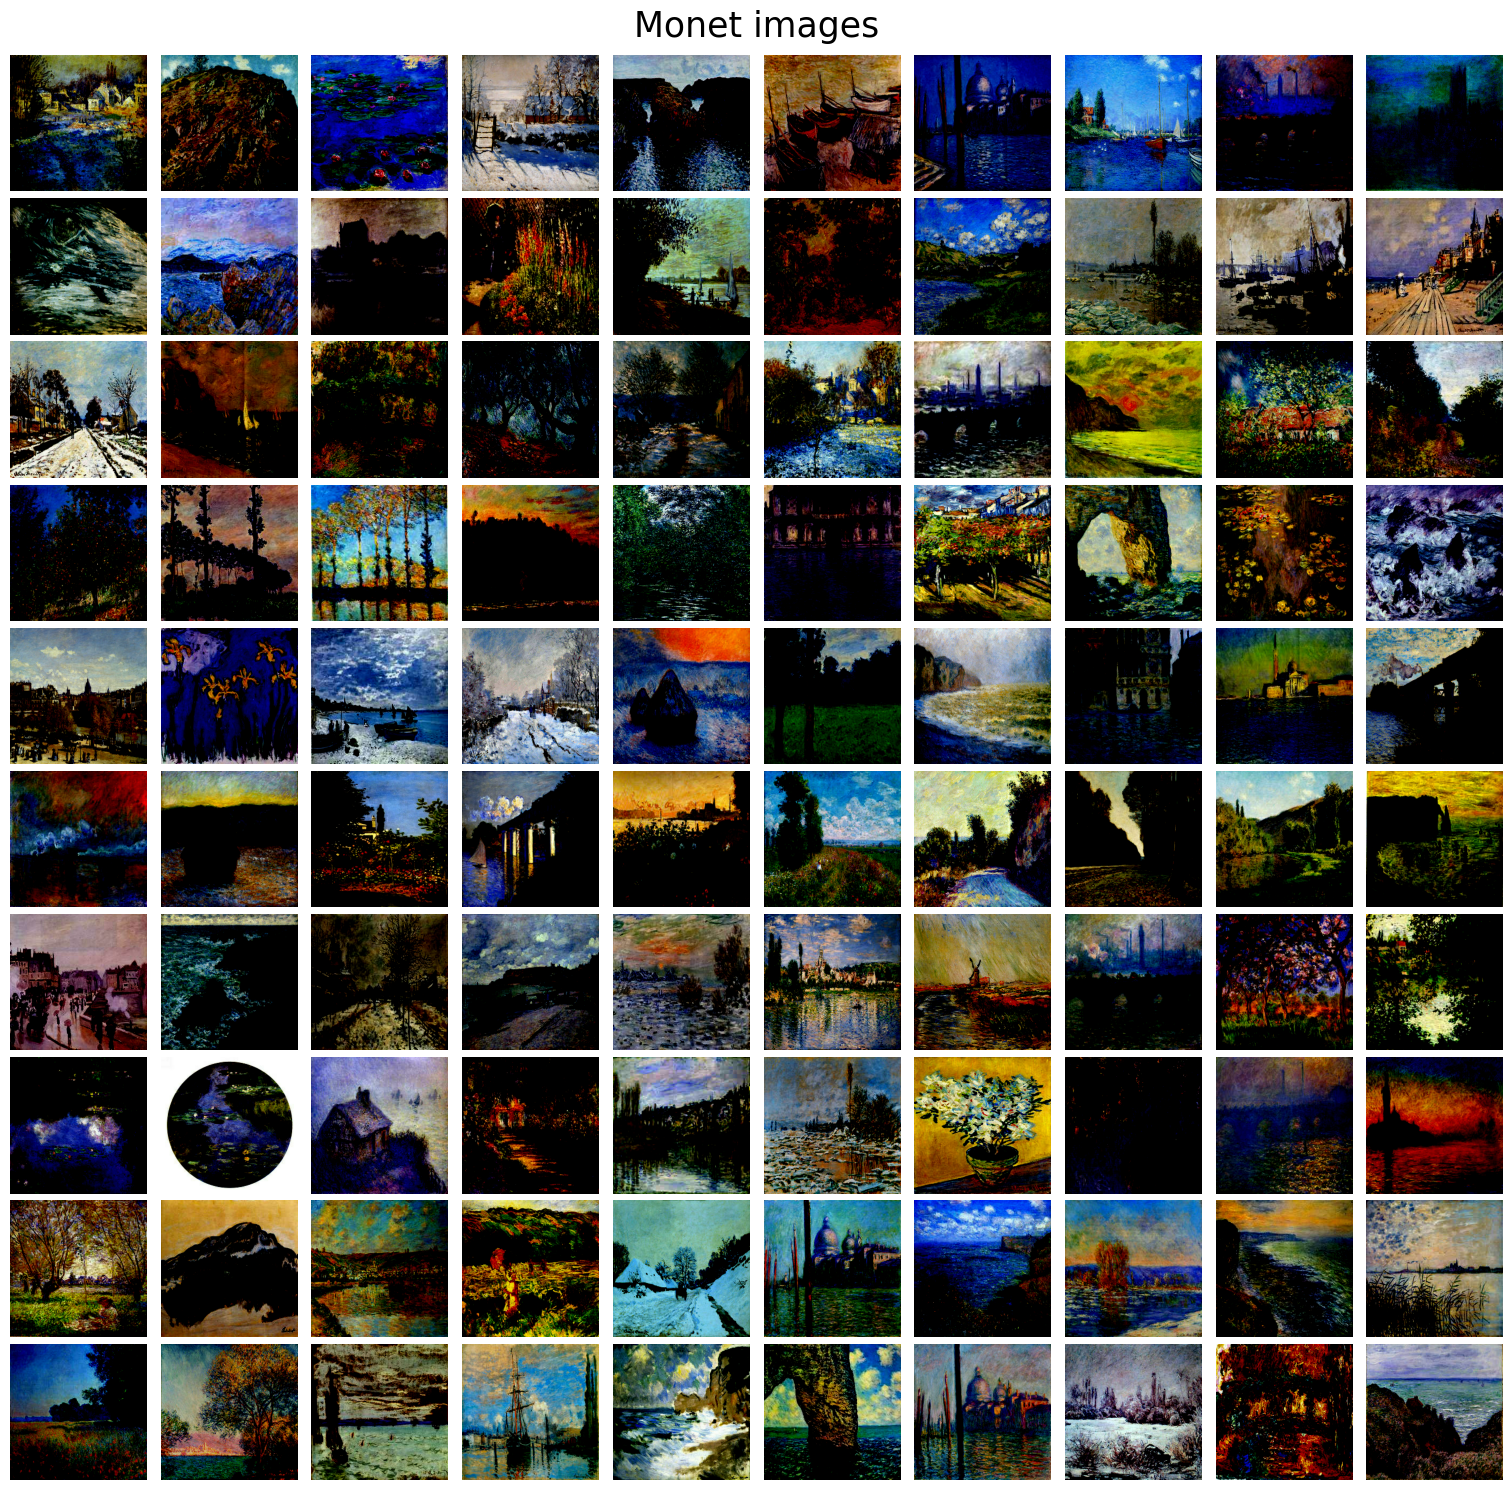

In [3]:
def plot_images(images, title):
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
    j = 1
    for i in np.random.choice(len(images), 100, replace=False):
        plt.subplot(10,10,j), plt.imshow(images[i] / images[i].max()), plt.axis('off')
        j += 1
    plt.suptitle(title, size=25)
    plt.show()

monet_numpy = list(monet_ds.as_numpy_iterator())
plot_images(monet_numpy, 'Monet images')

### Monet Style input images

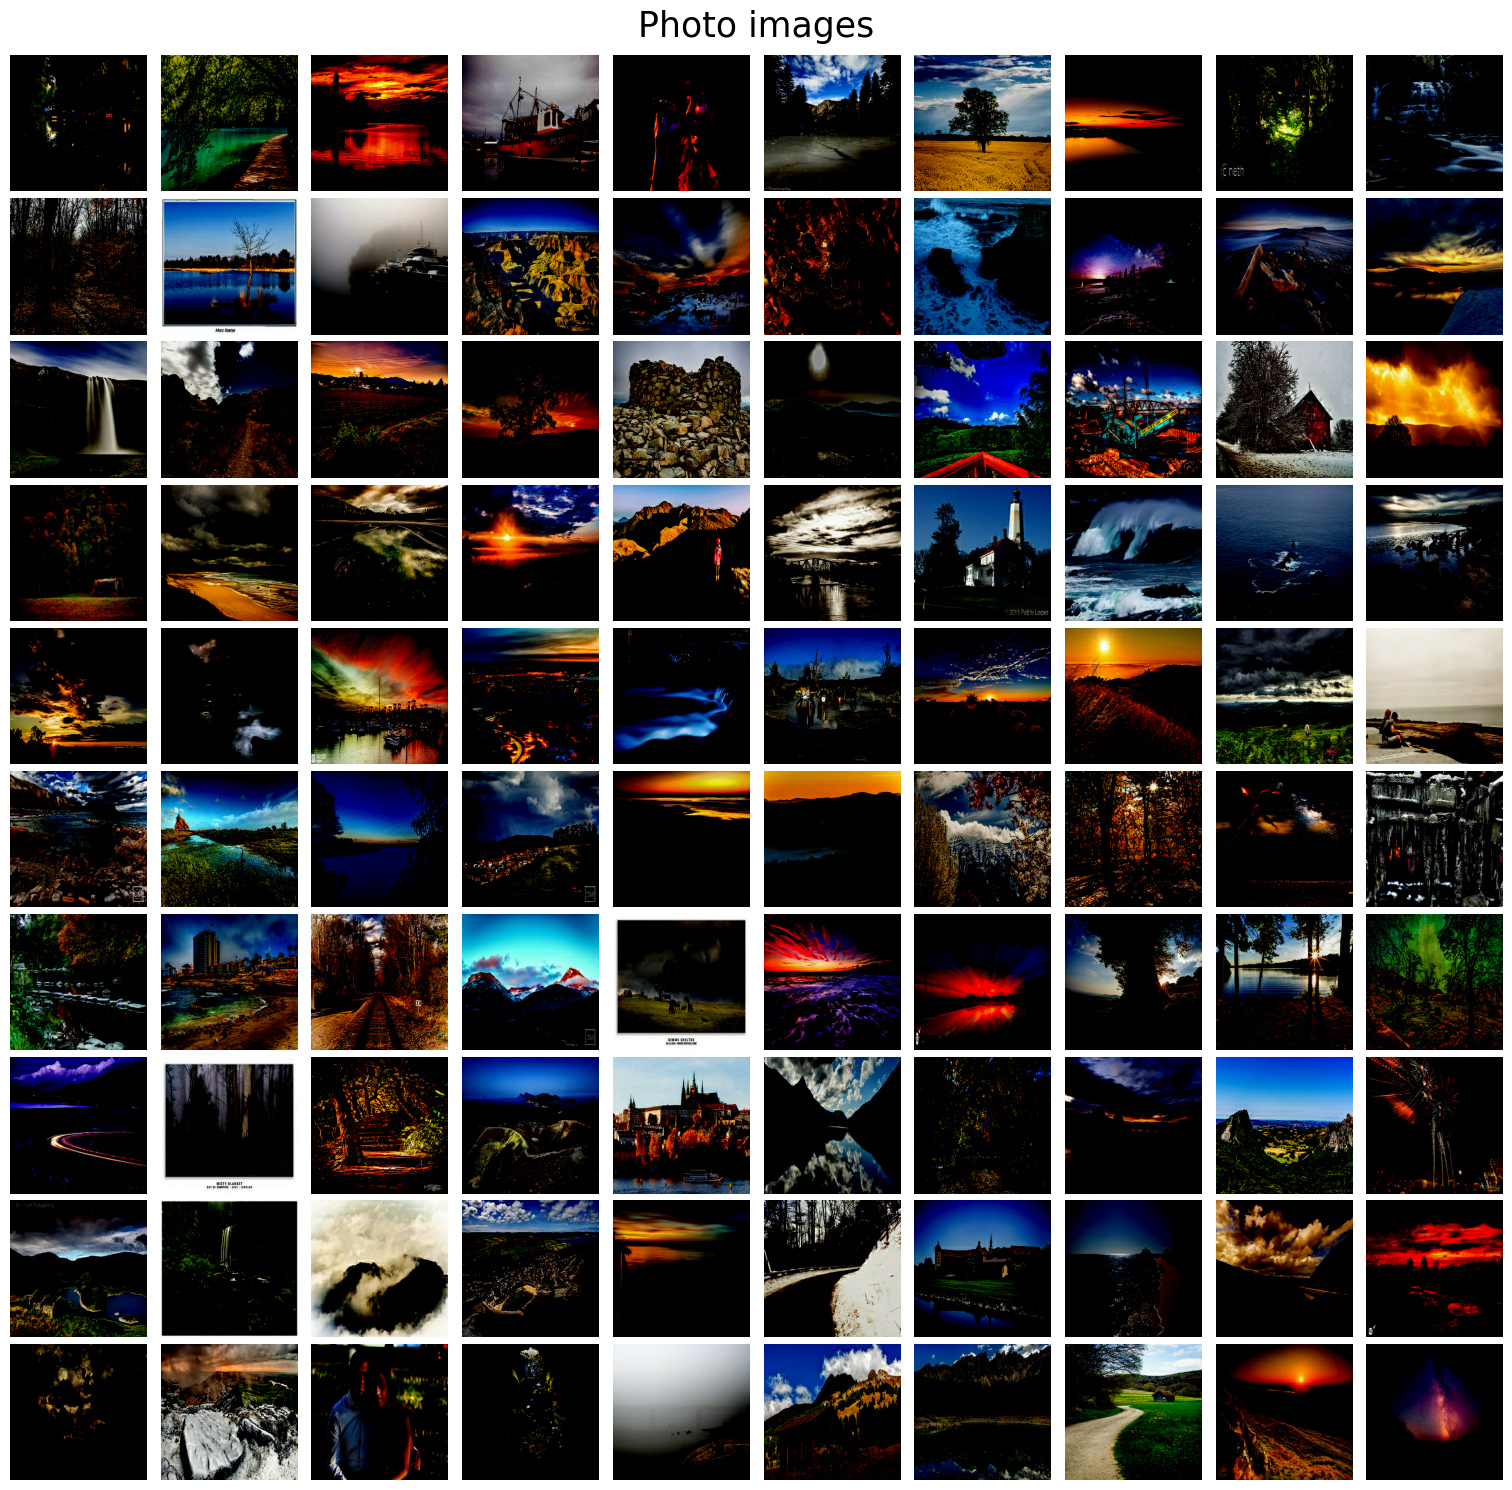

In [4]:
plot_images(list(photo_ds.as_numpy_iterator()), 'Photo images')

## Preprocessing

The images are transformed to have values in between [-1,1], implemented with the function `decode_image()` above. This is what I did and found to be the most common form of pre processing. I reviewed the top scored public code and saw they use something called a CLIP model to extract features during the transformation process. This is a pre trained model used. This is not something I implemented here but discuss in my future work section. 



## Model Architecture

Paired data is harder to find in most domains and not something we have here which makes the unsupervised training capabilities of **CycleGAN** quite useful, it does not require paired training data. The problem can be forumulated as unpaired image-to-image translation and CycleGAN is an ideal model to be used here. We shall train the CycleGAN model on the image dataset provided and then use the Genrator to generate monet images later.

In [5]:
import numpy as np
import re, os, shutil
from glob import glob
import tqdm
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model  # Ensure Model is imported

class CycleGAN(Model):  # Define CycleGAN inheriting from Model
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def generate(self, image):
        return self.m_gen(tf.expand_dims(image, axis=0), training=False)

    def load(
        self, 
        filepath
    ):
        self.m_gen.load_weights(filepath.replace('model_name', 'm_gen'), by_name=True)
        self.p_gen.load_weights(filepath.replace('model_name', 'p_gen'), by_name=True)
        self.m_disc.load_weights(filepath.replace('model_name', 'm_disc'), by_name=True)
        self.p_disc.load_weights(filepath.replace('model_name', 'p_disc'), by_name=True)

    def save(
        self, 
        filepath
    ):
        self.m_gen.save(filepath.replace('model_name', 'm_gen'))
        self.p_gen.save(filepath.replace('model_name', 'p_gen'))
        self.m_disc.save(filepath.replace('model_name', 'm_disc'))
        self.p_disc.save(filepath.replace('model_name', 'p_disc'))

        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            real_photo = tf.expand_dims(real_photo, axis=0)
            real_monet = tf.expand_dims(real_monet, axis=0)

            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        total_loss = total_monet_gen_loss + total_photo_gen_loss + monet_disc_loss + photo_disc_loss

        return {
            "total_loss": total_loss,
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


## CycleGAN Architecture

The CycleGAN is an extension of the GAN architecture designed for image-to-image translation tasks. Unlike the standard GAN, which involves a single generator and discriminator, the CycleGAN architecture involves the simultaneous training of two generator models and two discriminator models.

### Cycle Consistency Loss
This is the core idea that distinguishes CycleGAN from other GANs. It ensures that an image translated to the target domain and then back to the source domain should match the original image. This is implemented by introducing a *cycle* consistency loss:

**Forward Cycle Consistency Loss**: Ensures that translating an image from Domain A (photos) to Domain B (Monet paintings) and back to Domain A reconstructs the original image.

**Backward Cycle Consistency Loss**: Ensures that translating an image from Domain B to Domain A and back to Domain B reconstructs the original image.

## Discriminator Models
Two discriminator models are used:

**Discriminator A**: Differentiates between real images from Domain A and fake images generated by the generator from Domain B to Domain A.

**Discriminator B**: Differentiates between real images from Domain B and fake images generated by the generator from Domain A to Domain B.

## Generator Models
Two generator models are used:

**Generator A to B**: Transforms images from Domain A (photos) to Domain B (Monet paintings).

**Generator B to A**: Transforms images from Domain B (Monet paintings) to Domain A (photos).

## Model Architecture
**Generators**: Typically use an encoder-decoder or U-Net architecture. The encoder downsamples the input image to a bottleneck layer, and the decoder upsamples it back to the original size. The use of residual blocks (ResNet layers) with skip connections is common to help preserve image details.

**Discriminators**: Deep convolutional neural networks (often PatchGANs) that classify whether images are real or fake.

## Training Process

**Discriminators**
Trained to distinguish real images from fake images generated by the corresponding generator.

**Generators**
Trained to fool the discriminators and to minimize the cycle consistency loss. The loss function for the generators combines:

**Adversarial Loss**: Ensures the generated images look similar to the target domain.

**Cycle Consistency Loss**: Ensures that the translated images can be accurately reconstructed back to the original domain.

In [6]:
def Generator(img_shape=[256, 256, 3]):
    inputs = tf.keras.layers.Input(shape=img_shape)
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [7]:
def Discriminator(img_shape=[256, 256, 3]):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = tf.keras.layers.Input(shape=img_shape, name='input_image')
    x = inp

    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)

    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = tf.keras.layers.LayerNormalization(gamma_initializer=gamma_init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inp, outputs=x)


In [8]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tf.keras.layers.LayerNormalization(gamma_initializer=gamma_init))
    result.add(tf.keras.layers.LeakyReLU())
    
    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.LayerNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
    
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

        
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, LAMBDA):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

In [9]:
img_shape = [256, 256, 3]

model = CycleGAN(
    monet_generator=Generator(img_shape),
    photo_generator=Generator(img_shape),
    monet_discriminator=Discriminator(img_shape),
    photo_discriminator=Discriminator(img_shape),
    lambda_cycle=10
)

model.compile(
    m_gen_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    p_gen_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    m_disc_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    p_disc_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)

## Results and Analysis

Let's train the GAN model both the generator and discrimnator for 20 epochs. We expect to see the generator and discriminator "compete" with the discriminator attempting to correctly classify real images from generated images. The generator attempts to learn how to translate images from one domain (e.g., photos) to another domain (e.g., Monet paintings) and vice versa. In an ideal setting, the discriminator should have a hard time distinguishing real images from generated images, meaning the discriminator's loss should not necessarily be zero. If the discriminator's loss were zero, it would indicate that it perfectly distinguishes real from generated images, implying that the generator is not producing realistic images. Conversely, the generator should be able to produce images that are indistinguishable from real images, achieving a balance where the discriminator is unable to easily classify real versus generated images.

From what I see in other notebooks submitted, more epochs performs better but my machine is very slow training this model with each epoch taking about 20 minutes to be run. A batch size of 32 has been chosen to try and reduce the training time. 

Note that below you will see only 5 epochs trained. This is because the time to run 20 epochs. For the kaggle submission, 20 epochs was used. I am using 5 below to display an output as an example of the code for the submission within coursera. 

In [ ]:
# Train the model
batch_size = 32
epochs = 5
history = model.fit(dataset, epochs=epochs, batch_size=batch_size)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1603s 5s/step - monet_disc_loss: 0.3279 - monet_gen_loss: 7.4684 - photo_disc_loss: 0.3852 - photo_gen_loss: 7.2888 - total_loss: 15.4703
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1532s 5s/step - monet_disc_loss: 0.4645 - monet_gen_loss: 4.9566 - photo_disc_loss: 0.6007 - photo_gen_loss: 4.6850 - total_loss: 10.7068
Epoch 3/5
255/300 ━━━━━━━━━━━━━━━━━━━━ 3:47 5s/step - monet_disc_loss: 0.4651 - monet_gen_loss: 4.5429 - photo_disc_loss: 0.5453 - photo_gen_loss: 4.2247 - total_loss: 9.7781

Save the model.

In [ ]:
model.save('cyclegan_SV.h5')

Plot the loss for the generators and discriminators, for generators we plot the mean loss.

In [ ]:
history.history.keys()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(hist):
    monet_gen_loss = np.array(hist.history['monet_gen_loss'][0][0])
    photo_gen_loss = np.array(hist.history['photo_gen_loss'][0][0])
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    plt.plot(monet_gen_loss.flatten())
    plt.plot(photo_gen_loss.flatten())
    plt.legend(["monet", "photo"])
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.title('Generator Loss over Epochs')
    
    plt.subplot(122)
    monet_disc_loss = np.array(hist.history['monet_disc_loss'][0][0])
    photo_disc_loss = np.array(hist.history['photo_disc_loss'][0][0])
    plt.plot(monet_disc_loss.flatten())
    plt.plot(photo_disc_loss.flatten())
    plt.legend(["monet", "photo"])
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.title('Discriminator Loss over Epochs')
    
    plt.tight_layout()
    plt.show()

# Assuming 'history' is the result of model.fit
plot_hist(history)


Finally, let's use the generated to generate ~7k images and save / submit the notebook to kaggle.

In [ ]:
! mkdir ../images

def generate(dataset):
    dataset_iter = iter(dataset)
    out_dir = '../images/'
    for i in tqdm.tqdm(range(n_photo_samples)):
        # Get the image from the dataset iterator
        img = next(dataset_iter)
        prediction = model.generate(img)
        prediction = tf.squeeze(prediction).numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   
        plt.imsave(os.path.join(out_dir, 'image_{:04d}.jpg'.format(i)), prediction)

generate(photo_ds)

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

## Conclusion and Future Work

The CycleGAN does a pretty good job in generating the monet-style images from photos. The model was trained for 20 epochs, it seems that losses will decrease further if increased for more epochs (e.g., 100), we can get a better model. However, my machine is very slow at training this model with it taking roughly 5-8 hours depending on the amount of epochs I use. 

With this in mind, future work would include optimizing the code to run faster and attempting to implement a strategy that utilzied GPU and/or parellel computing. At this time, I have spent significant time on this model to get it to this point and need to move on but I hope to learn more about these methods and attempt to implement them in the future. I think improving the computation of the code will have the largest impact as from what I have read in other notebooks and online, being able to tune the model depends on the computing power of the machine. For instance, being able to run more epochs. 

Kaggle uses an evaluation metric called MiFID (Memorization-informed Fréchet Inception Distance) score to evaluate the quality of generated images.